In [16]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
#from IPython.display import Image
import matplotlib.patches as patches
from PIL import Image

c:\Users\agreen\miniconda3\envs\ml-env\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


In [17]:
# Import openstreetmap
import osmnx as ox
import geojson 
import geopandas as gpd

In [18]:
# Define the area of interest (AOI). Dominica OSMID = "R7161200"
place_name = "Dominica"
area_of_interest = ox.geocode_to_gdf(query="R7161200", by_osmid=True)
area_of_interest

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((-61.48012 15.53727, -61.47996 15.536...",15.640275,15.207632,-61.240093,-61.480117,279325653,relation,7161200,15.424043,-61.341853,place,island,17,0.678697,island,Dominica,"Dominica, Roseau, Saint Joseph Parish, Dominica"


Geometry is valid for OSMnx.


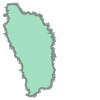

In [132]:
#convert GDF to polygon and check its valid for OSMNX

from shapely.geometry import Polygon, MultiPolygon, MultiLineString

# Assuming `area of interest` contains a single row with the area of interest
area_of_interest_poly = area_of_interest.geometry.iloc[0]

# Ensure it's a valid polygon or multipolygon for OSMnx
if isinstance(area_of_interest_poly, (Polygon, MultiPolygon)):
    print("Geometry is valid for OSMnx.")
else:
    raise ValueError("The geometry is not a Polygon or MultiPolygon.")
area_of_interest_poly

In [20]:
#Get bridges from area of interest
bridges = ox.features_from_polygon(area_of_interest_poly, tags={
    'bridge': True
    })

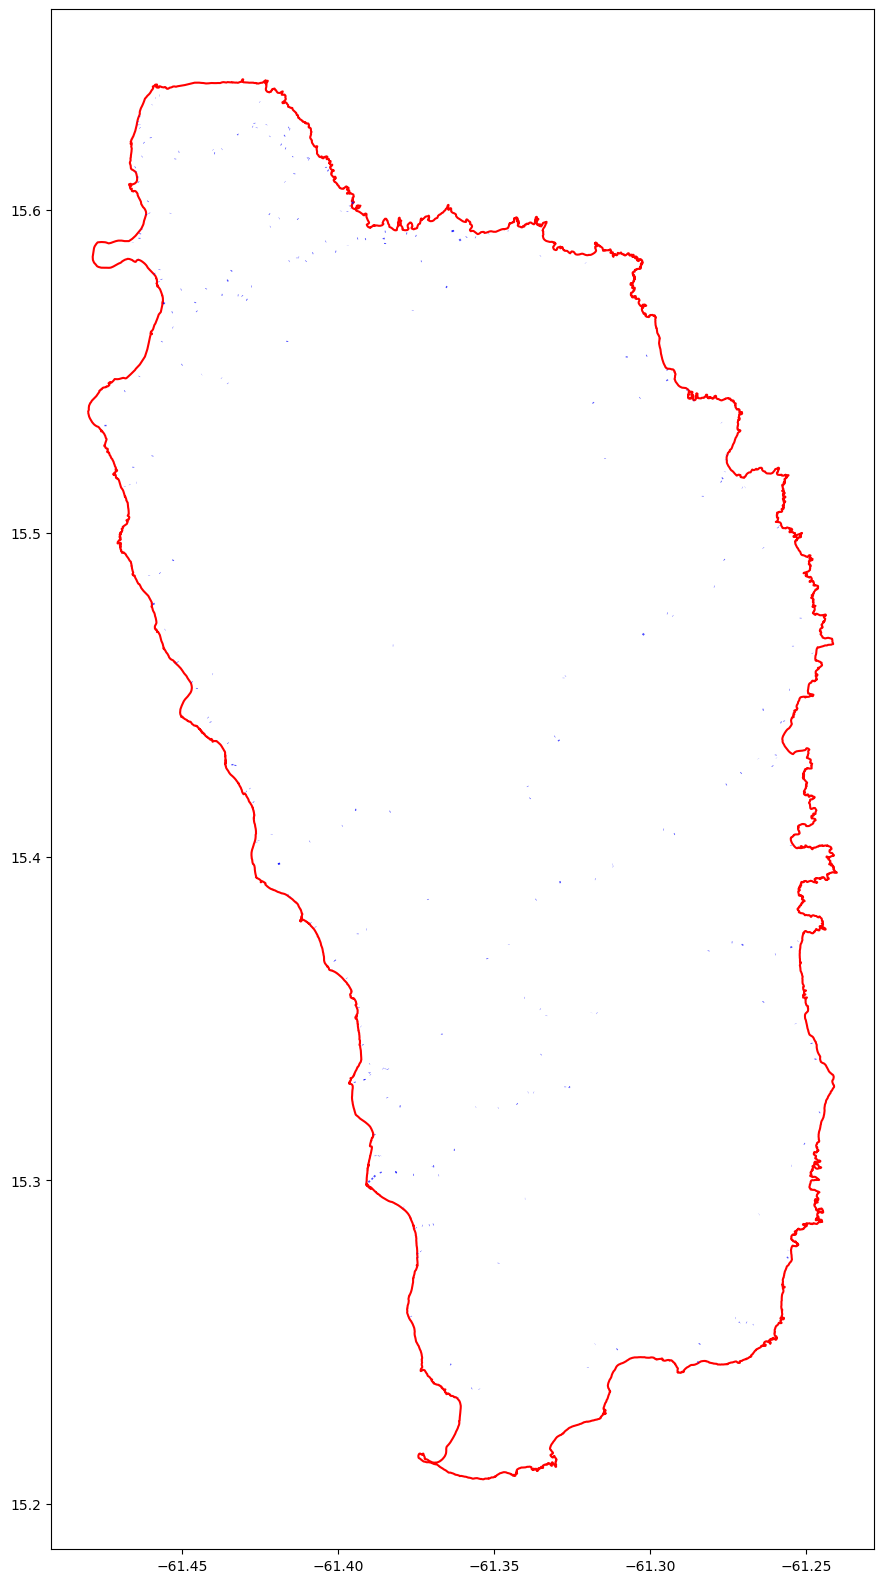

In [21]:
# Plot the area and buildings for visualization

fig, ax = plt.subplots(figsize=(20,20))
area_of_interest.boundary.plot(ax=ax, color="red")
bridges.plot(ax=ax, color="blue", alpha=0.7)
plt.show()

In [22]:
bridges
# Save the building footprints for further use
bridges.to_file("./Data/dominica_all_bridges.geojson", driver="GeoJSON")
#Don't know why this throws an error it seems to work fine.

# Filter bridges to remove footpaths etc that are not roads or visible from space
# Could be done through checking against distance from roads and/riverways


In [23]:
#Overlay bridges to Satellite imagery
#get the sentinel-2 imagery from  sentinelhub . Other options will work as well.
from sentinelhub import SHConfig
from sentinelhub import (
    SentinelHubRequest, 
    DataCollection, 
    MimeType, 
    bbox_to_dimensions, 
    BBox, 
    CRS, 
    WmsRequest, 
    WcsRequest, 
    BBoxSplitter,
)

#sign up for an account here: https://www.sentinel-hub.com/develop/dashboard/
# Load SentinelHub configuration
config = SHConfig()
#config.instance_id = ''
#config.sh_client_id = ''
#config.sh_client_secret = ''

In [24]:
# Coordinates for Dominica
bounds = area_of_interest.total_bounds  # returns [minx, miny, maxx, maxy]
dominica_bbox = BBox(bbox=[bounds[0], bounds[1], bounds[2], bounds[3]], crs=CRS.WGS84) #Need to specifiy the coordinate system
dominica_bbox

BBox(((-61.4801175, 15.2076318), (-61.2400927, 15.6402755)), crs=CRS('4326'))

In [25]:
# Define the resolution (10m per pixel)
resolution = 10  # 10 meters per pixel.
size = bbox_to_dimensions(dominica_bbox, resolution)

In [26]:
# Define the Sentinel-2 imagery request (True Color Composite)
#request = SentinelHubRequest(
    #evalscript="""
       # // Normalized True Color script
        #return [B04 * 2.5, B03 * 2.5, B02 * 2.5]; // Sentinel-2 bands for RGB
    #""",
    #input_data=[
     #   SentinelHubRequest.input_data(
      #      data_collection=DataCollection.SENTINEL2_L1C,
       #     time_interval=('2017-08-01', '2017-09-01')  # Date range before hurricane
        #)
    #],
    #data_folder= "./Data/Sentinel_Imagery_10m_RGB/",
    #responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    #bbox=dominica_bbox,
    #size=bbox_to_dimensions(dominica_bbox, resolution),
    #config=config
#)

Get the Sentinel-2 Data using WMS request

In [27]:
#True Colour WMS Request - Config
wms_true_color_request = WmsRequest(
    data_collection=DataCollection.SENTINEL2_L1C,
    data_folder= "./Data/Sentinel_Imagery_10m_RGB/",
    layer="1_TRUE_COLOR", #layer set in SentinelHub Dashboard
    bbox=dominica_bbox,
    time=("2017-08-01","2017-09-10"), #1 month of data before event
    width=512,
    height=856,
    maxcc=0.2, #20% cloud cover
    image_format=MimeType.TIFF,
    config=config,
)

In [28]:
#True Colour WMS - Get Data
wms_true_color_img = wms_true_color_request.get_data(save_data=True)

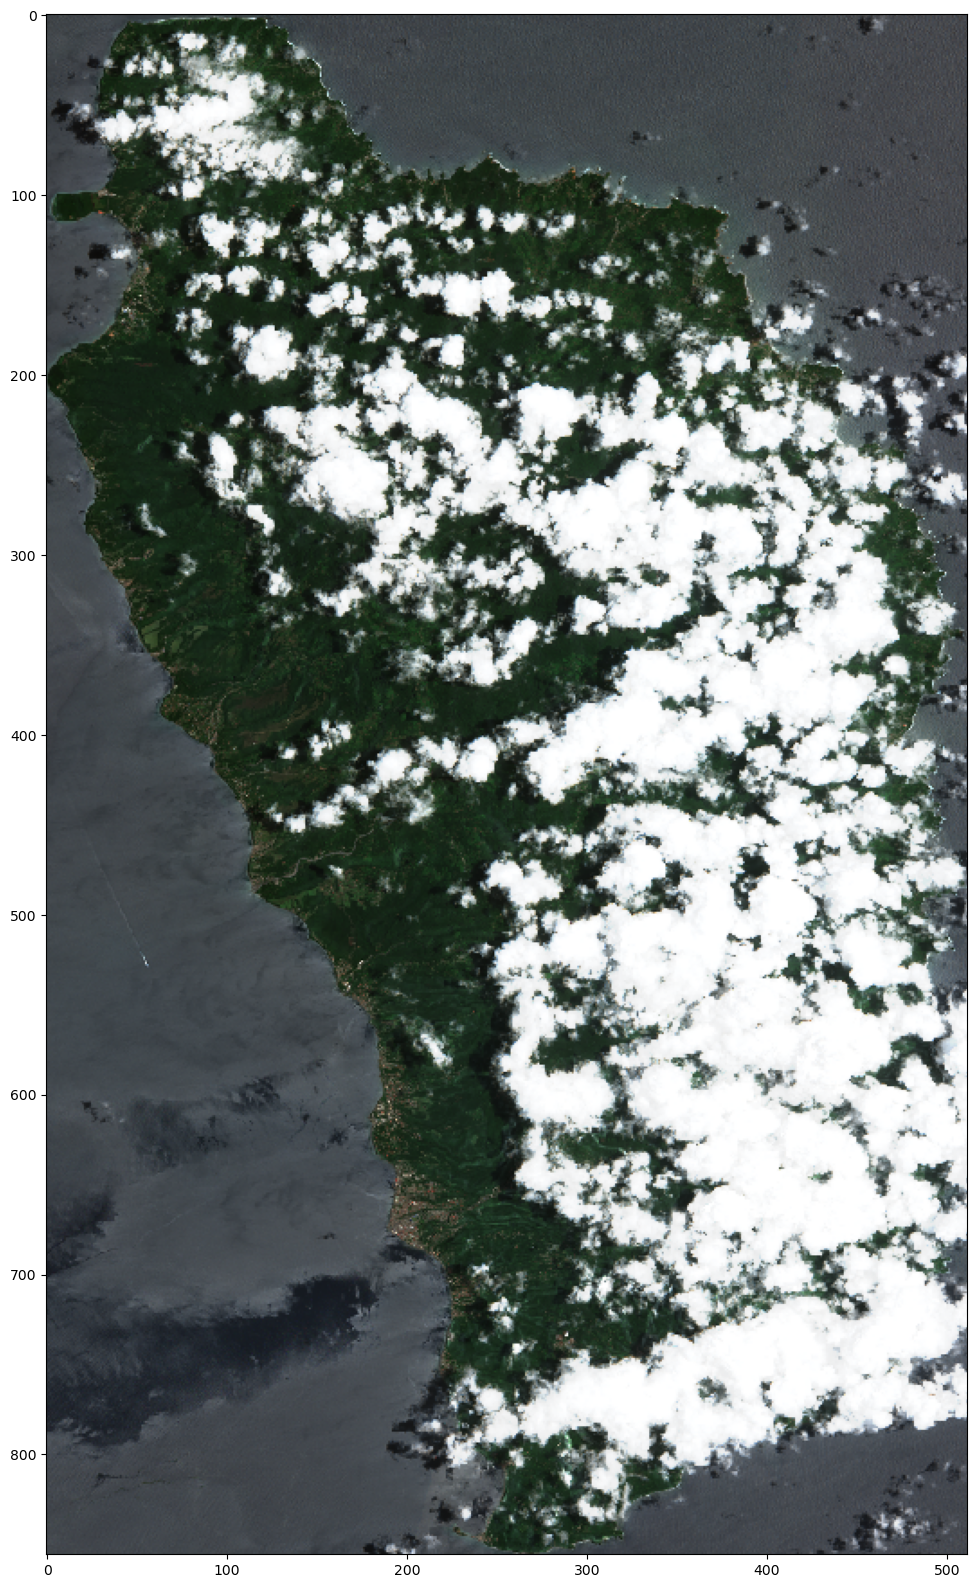

In [29]:
#Visualise it
image_wms = wms_true_color_img[0]
fig, ax = plt.subplots(1, 1, figsize=(20,20))
ax.imshow(image)

Get the Sentinel 2 data using a WCS request which allows you to pick a resolution

In [ ]:
#WCS requests only allow for 2500x2500 pixels at 10m. Use a bounding box around Roseau as an example
roseau_coords = (-61.398897,15.290201, -61.37392,15.312154)
roseau_bbox = BBox(bbox=roseau_coords, crs=CRS.WGS84)

In [ ]:
#Want to get imagery for the whole of Dominica at this resolution. So need to breakdown the Dominica BBox 
# to smaller sections
#For 1 degree of latitude and long = about 111,132 meters
dominica_width = ((61.4801175 - 61.2400927)*111132)
dominica_height = ((15.6402755 - 15.2076318)*111132)
dominica_10m_pixels_width = dominica_width/10
dominica_10m_pixels_height = dominica_height/10
dominica_tile_width = dominica_10m_pixels_width/2500
dominica_tile_height = dominica_10m_pixels_height/2500
print("Dominica is: ", dominica_tile_width, "tiles wide and: ", dominica_tile_height, "tiles tall")

Dominica is:  1.0669774429440022 wide and:  1.9232223867359992 tall


In [123]:
#Split Dominica bbox into a few tiles. 2x2 tiles.
minx, miny, maxx, maxy = -61.4801175, 15.2076318, -61.2400927, 15.6402755
dominica_bbox_poly = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)])
bbox_splitter = BBoxSplitter([dominica_bbox_poly], CRS.WGS84, split_shape=(2, 2))

print("Area bounding box: {}\n".format(bbox_splitter.get_area_bbox().__repr__()))
bbox_list = bbox_splitter.get_bbox_list()
info_list = bbox_splitter.get_info_list()

print(
    "Each bounding box also has some info how it was created.\nExample:\nbbox: {}\ninfo: {}\n".format(
        bbox_list[0].__repr__(), info_list[0]
    )
)

Area bounding box: BBox(((-61.4801175, 15.2076318), (-61.2400927, 15.6402755)), crs=CRS('4326'))

Each bounding box also has some info how it was created.
Example:
bbox: BBox(((-61.4801175, 15.2076318), (-61.3601051, 15.42395365)), crs=CRS('4326'))
info: {'parent_bbox': BBox(((-61.4801175, 15.2076318), (-61.2400927, 15.6402755)), crs=CRS('4326')), 'index_x': 0, 'index_y': 0}



In [127]:
pip install basemap

  Using cached pyproj-3.6.1-cp312-cp312-win_amd64.whl.metadata (31 kB)
   ---------------------------------------- 0.0/30.5 MB ? eta -:--:--
   ------- -------------------------------- 5.8/30.5 MB 29.3 MB/s eta 0:00:01
   ---------------- ----------------------- 12.3/30.5 MB 29.7 MB/s eta 0:00:01
   ------------------- -------------------- 14.9/30.5 MB 27.6 MB/s eta 0:00:01
   ------------------- -------------------- 14.9/30.5 MB 27.6 MB/s eta 0:00:01
   ------------------- -------------------- 14.9/30.5 MB 27.6 MB/s eta 0:00:01
   ------------------- -------------------- 14.9/30.5 MB 27.6 MB/s eta 0:00:01
   ------------------- -------------------- 14.9/30.5 MB 27.6 MB/s eta 0:00:01
   -------------------- ------------------- 15.7/30.5 MB 9.0 MB/s eta 0:00:02
   -------------------- ------------------- 15.7/30.5 MB 9.0 MB/s eta 0:00:02
   -------------------- ------------------- 16.0/30.5 MB 7.5 MB/s eta 0:00:02
   -------------------- ------------------- 16.0/30.5 MB 7.5 MB/s eta 0:0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keplergl 0.3.2 requires ipywidgets<8,>=7.0.0, but you have ipywidgets 8.1.5 which is incompatible.
c:\Users\agreen\miniconda3\envs\ml_env\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedWriter name=4>
  return process_handler(cmd, _system_body)
c:\Users\agreen\miniconda3\envs\ml_env\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=5>
  return process_handler(cmd, _system_body)
c:\Users\agreen\miniconda3\envs\ml_env\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  return process_handler(cmd, _system_body)


In [140]:
from mpl_toolkits.basemap import Basemap 
import rioxarray  # noqa: F401 # Its necesary for xarray.open_mfdataset() with engine `rasterio`
import xarray as xr  # It may need Dask library https://docs.dask.org/en/stable/install.html
from matplotlib.patches import Polygon as PltPolygon
def show_splitter(splitter, alpha=0.2, area_buffer=0.2, show_legend=False):
    area_bbox = splitter.get_area_bbox()
    minx, miny, maxx, maxy = area_bbox
    lng, lat = area_bbox.middle
    w, h = maxx - minx, maxy - miny
    minx = minx - area_buffer * w
    miny = miny - area_buffer * h
    maxx = maxx + area_buffer * w
    maxy = maxy + area_buffer * h

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    base_map = Basemap(
        projection="mill",
        lat_0=lat,
        lon_0=lng,
        llcrnrlon=minx,
        llcrnrlat=miny,
        urcrnrlon=maxx,
        urcrnrlat=maxy,
        resolution="l",
        epsg=4326,
    )
    base_map.drawcoastlines(color=(0, 0, 0, 0))

    area_shape = splitter.get_area_shape()

    if isinstance(area_shape, Polygon):
        polygon_iter = [area_shape]
    elif isinstance(area_shape, MultiPolygon):
        polygon_iter = area_shape.geoms
    else:
        raise ValueError(f"Geometry of type {type(area_shape)} is not supported")

    for polygon in polygon_iter:
        if isinstance(polygon.boundary, MultiLineString):
            for linestring in polygon.boundary:
                ax.add_patch(PltPolygon(np.array(linestring), closed=True, facecolor=(0, 0, 0, 0), edgecolor="red"))
        else:
            ax.add_patch(
                PltPolygon(np.array(polygon.boundary.coords), closed=True, facecolor=(0, 0, 0, 0), edgecolor="red")
            )

    area_of_interest.boundary.plot(ax=ax, color="red")
    bbox_list = splitter.get_bbox_list()
    info_list = splitter.get_info_list()

    cm = plt.get_cmap("jet", len(bbox_list))
    legend_shapes = []
    for i, bbox in enumerate(bbox_list):
        wgs84_bbox = bbox.transform(CRS.WGS84).get_polygon()

        tile_color = tuple(list(cm(i))[:3] + [alpha])
        ax.add_patch(PltPolygon(np.array(wgs84_bbox), closed=True, facecolor=tile_color, edgecolor="green"))

        if show_legend:
            legend_shapes.append(plt.Rectangle((0, 0), 1, 1, fc=cm(i)))

    if show_legend:
        legend_names = []
        for info in info_list:
            legend_name = "{},{}".format(info["index_x"], info["index_y"])

            for prop in ["grid_index", "tile"]:
                if prop in info:
                    legend_name = "{},{}".format(info[prop], legend_name)

            legend_names.append(legend_name)

        plt.legend(legend_shapes, legend_names) 
    plt.tight_layout()
    plt.show()

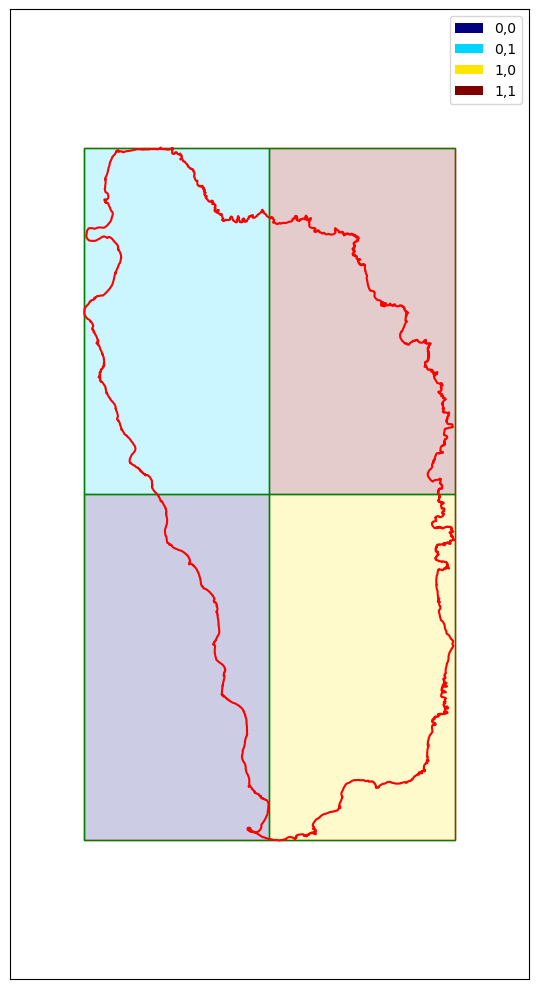

In [141]:
show_splitter(bbox_splitter, show_legend=True)

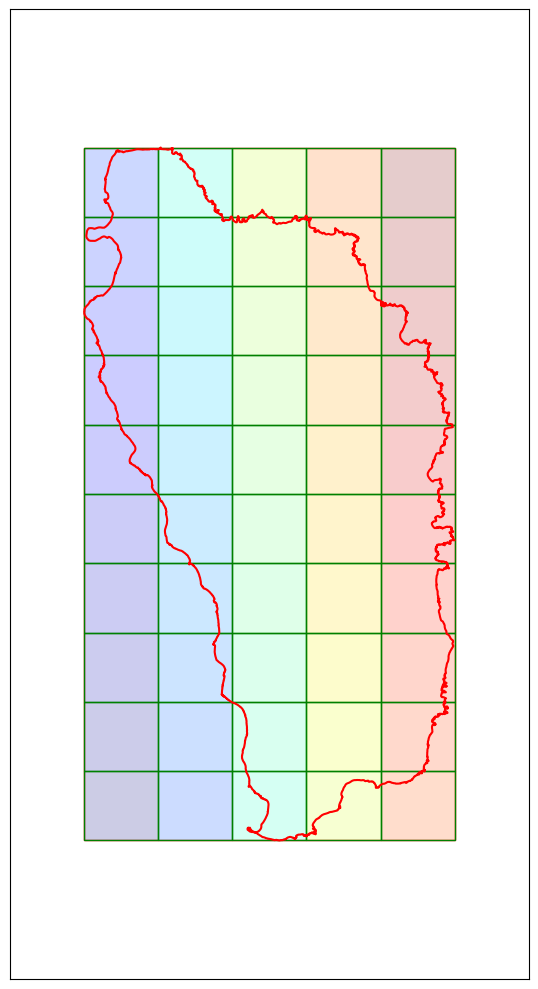

In [142]:
bbox_splitter_reduced = BBoxSplitter([dominica_bbox_poly], CRS.WGS84, (5, 10), reduce_bbox_sizes=True)

show_splitter(bbox_splitter_reduced, show_legend=False)

In [ ]:
#True Colour WCS Request - Config
wcs_true_color_request = WcsRequest(
    data_collection=DataCollection.SENTINEL2_L1C,
    data_folder= "./Data/Sentinel_Imagery_10m_RGB/",
    layer="1_TRUE_COLOR",
    bbox=roseau_bbox,
    time=("2017-08-01","2017-09-10"),
    resx="10m",
    resy="10m",
    maxcc=0.2,
    image_format=MimeType.TIFF,
    config=config,
)

In [83]:
#True Colour WcS - Get Data
wcs_true_color_img = wcs_true_color_request.get_data(save_data=True)

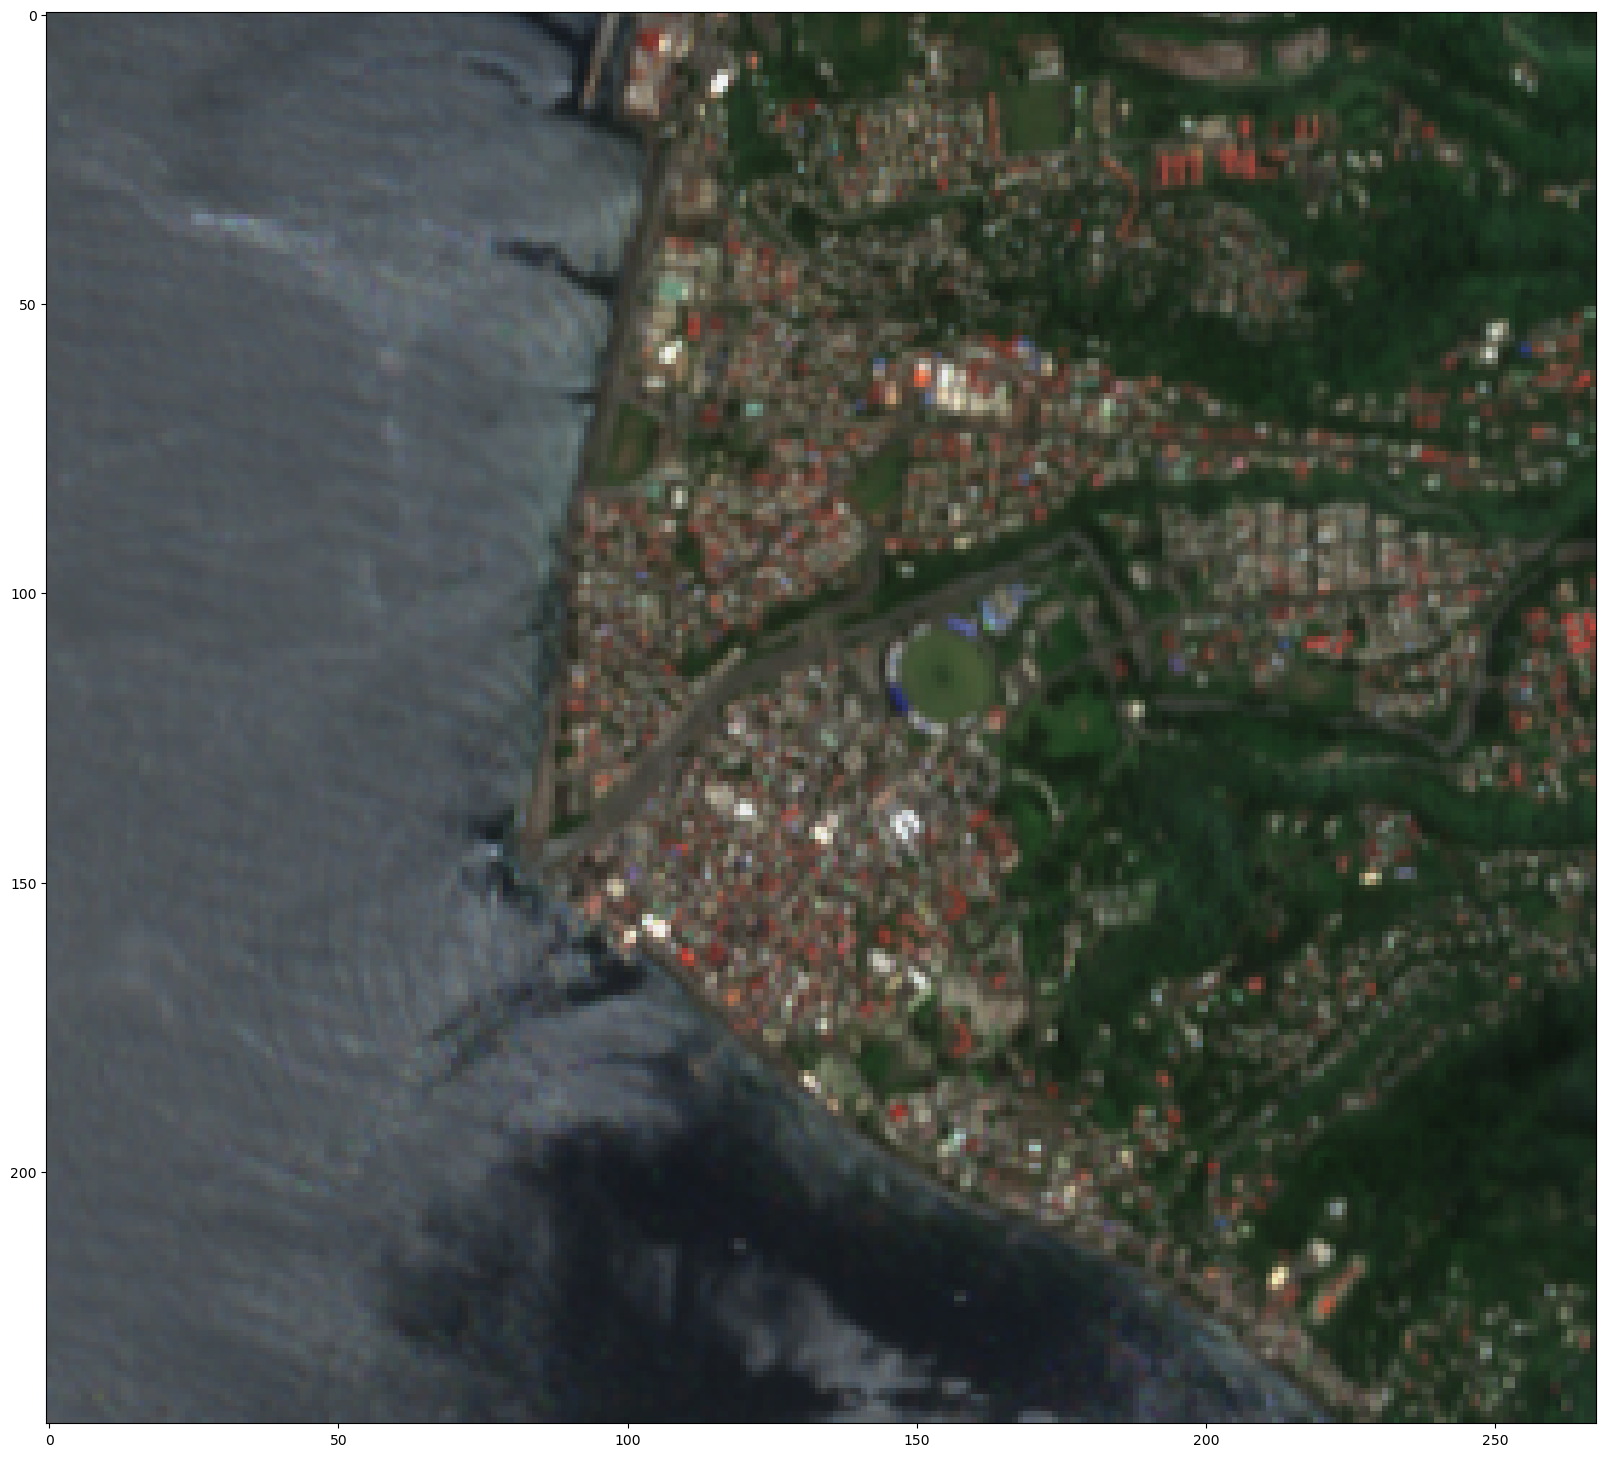

In [84]:
#Visualise it
image_wcs = wcs_true_color_img[0]
fig, ax = plt.subplots(1, 1, figsize=(20,20))
ax.imshow(image_wcs)

In [30]:
print("The latest Sentinel-2 image of this area was taken on {}.".format(wms_true_color_request.get_dates()[-1]))

The latest Sentinel-2 image of this area was taken on 2017-09-09 14:47:29.
